In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import optuna

from reinforcetrader.data_pipeline import RawDataLoader

# Supress optuna optimization INFO logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Defining the Reward Functions

We first define certain notations used in the reward functions:

$$
\large H_b = \{10, 15, 20, 25\}, \quad H_s = \{3, 5, 10\}.
$$

$$
\large
R_h^{\mathrm{ex}}(t)
= \ln\!\left(\frac{P_{t+h}}{P_t}\right)
  - \ln\!\left(\frac{B_{t+h}}{B_t}\right).
$$

$$
\large
w_{h,S,\tau}^{+}(t)
= \frac{e^{R_h^{\mathrm{ex}}(t)/\tau}}
       {\sum_{j \in S} e^{R_j^{\mathrm{ex}}(t)/\tau}},
\quad
w_{h,S,\tau}^{-}(t)
= \frac{e^{-R_h^{\mathrm{ex}}(t)/\tau}}
       {\sum_{j \in S} e^{-R_j^{\mathrm{ex}}(t)/\tau}},
\space
\mathrm{where}\space h \in S
$$

The reward functions are defined as:

$$
\large
r_{\mathrm{buy}}^{t}
= \gamma \cdot \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
\large
r_{\mathrm{hold\mbox{-}out}}^{t}
= \alpha \cdot \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \beta \cdot \max\!\left(0,\,
  \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$

$$
\large
r_{\mathrm{sell}}^{t}
= \lambda \cdot \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
\large
r_{\mathrm{hold\mbox{-}in}}^{t}
= \max\!\left(0,\,
  \upsilon \cdot \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  + \mu \cdot \sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$


In [2]:
# define function to compute the weights for excess return horizons
def softmax_weights(er: pd.DataFrame, S: list[int], tau: float, positive: bool = True) -> np.ndarray:
    if tau <= 0:
        raise ValueError("tau must be > 0")
    cols = [f"{h}ER" for h in S]
    X = er[cols].to_numpy(dtype=float, copy=False)
    sign = 1.0 if positive else -1.0
    logits = (sign * X) / float(tau)
    m = np.max(logits, axis=1, keepdims=True)
    exp_shifted = np.exp(logits - m)
    W = exp_shifted / exp_shifted.sum(axis=1, keepdims=True)
    return W

# define function to compute the weighted sum of excess returns
def sum_weighted_returns(er: pd.DataFrame, S: list[int], tau: float, positive: bool = True) -> np.ndarray:
    cols = [f"{h}ER" for h in S]
    X = er[cols].to_numpy(dtype=float, copy=False)
    W = softmax_weights(er, S, tau, positive=positive)
    return (W * X).sum(axis=1)

In [3]:
def buy_reward(er: pd.DataFrame, Hb: list[int], tb, gamma: float = 1.0, cost: float = 0.005):
    return gamma * sum_weighted_returns(er, Hb, tb, positive=True) - cost

def hold_out_reward(er: pd.DataFrame, Hb, Hs: list[int], tb, ts, alpha: float = 1.0, beta: float = 1.0):
    avoid_loss = -sum_weighted_returns(er, Hs, ts, positive=False)
    miss_gain  = sum_weighted_returns(er, Hb, tb, positive=True)
    return alpha * np.maximum(0.0, avoid_loss) - beta * np.maximum(0.0, miss_gain)

def sell_reward(er: pd.DataFrame, Hs: list[int], ts, lam = 1.0, cost: float = 0.005):
    g = - lam * sum_weighted_returns(er, Hs, ts, positive=False)
    return np.maximum(0.0, g) - cost

def hold_in_reward(er: pd.DataFrame, Hb: list[int], Hs: list[int], tb, ts, upsilon: float = 1.0, mu: float = 1.0):
    g_pos = upsilon * sum_weighted_returns(er, Hb, tb, positive=True)
    g_neg = mu * sum_weighted_returns(er, Hs, ts, positive=False)
    return np.maximum(0.0, g_pos + g_neg)

In [4]:
# Helper functions used for analysis
def compute_returns(start_date, end_date, stock_ticker, index_ticker: str, horizons=list[int]) -> tuple[pd.DataFrame]:
    start = pd.to_datetime(start_date) + pd.DateOffset(days=-5)
    end = pd.to_datetime(end_date) + pd.DateOffset(days=60)
    
    # Download the data for stocks and the benchmark index
    data_loader = RawDataLoader(start_date=start, end_date=end, tickers=[stock_ticker, index_ticker], verbose=False)
    
    # Extract the close prices
    hist_prices = data_loader.get_hist_prices().xs(key='Close', level='Price', axis=1)
    
    # Compute excess returns on provided horizons
    excess_returns = pd.DataFrame(index=hist_prices.index)
    for h in horizons:
        hFR = np.log(hist_prices.shift(-h) / hist_prices)
        excess_returns[f'{h}ER'] = hFR[stock_ticker] - hFR[index_ticker]
    excess_returns.dropna(inplace=True)

    # Lastly, compute the cumulative returns
    cum_returns = (hist_prices.pct_change() + 1).cumprod().dropna()
    
    # Trim the index to the asked dates
    hist_prices = hist_prices.loc[start_date: end_date]
    cum_returns = cum_returns.loc[start_date: end_date]
    excess_returns = excess_returns.loc[start_date: end_date]
    
    return hist_prices, cum_returns, excess_returns

def compute_rewards(er: pd.DataFrame, reward_params: dict[str, object]) -> pd.DataFrame:
    # Extract reward function params
    Hb, Hs = reward_params['Hb'], reward_params['Hs']
    tb, ts = reward_params['tb'], reward_params['ts']
    cost = reward_params['cost']
    gamma = reward_params['gamma']
    alpha, beta = reward_params['alpha'], reward_params['beta']
    lam = reward_params['lambda']
    upsilon, mu = reward_params['upsilon'], reward_params['mu']
    
    Buy = buy_reward(er, Hb, tb, gamma, cost)
    HoldOut = hold_out_reward(er, Hb, Hs, tb, ts, alpha, beta)
    Sell = sell_reward(er, Hs, ts, lam, cost)
    HoldIn = hold_in_reward(er, Hb, Hs, tb, ts, upsilon, mu)

    rewards = pd.DataFrame({
        'Buy': Buy,
        'Hold-In': HoldIn,
        'Sell': Sell,
        'Hold-Out': HoldOut
    }, index=er.index)

    return rewards

# Reward Function Optimization

In [5]:
class RewardOptimizer:
    def __init__(self, fixed_params: dict[str, object], opt_params: dict[str, object], index: str='^DJI', ):
        self.index = index
        self.fixed_params = fixed_params
        self.opt_params = opt_params
        
        # Pre compute metrics for later use
        self._setup_study(index='^DJI')

        # Store the best params
        self._best_params = None
        
    def _setup_study(self, index: str) -> None:
        ticker_dl = RawDataLoader(start_date='1999-08-01', end_date='2019-12-09', index='DJI', verbose=False)
        self.hist_prices = ticker_dl.get_hist_prices().xs(key='Close', level='Price', axis=1)
        daily_stock_returns = np.log(self.hist_prices.shift(-1) / self.hist_prices)

        index_dl = RawDataLoader(start_date='1999-08-01', end_date='2019-12-09', tickers=[index], verbose=False)
        self.index_prices = index_dl.get_hist_prices().xs(key='Close', level='Price', axis=1)
        daily_index_returns = np.log(self.index_prices.shift(-1) / self.index_prices)

        self.daily_excess_returns = daily_stock_returns.sub(daily_index_returns[index], axis=0)
    
    def _get_trade_signals(self, params: dict[str, object])-> pd.DataFrame:
        Hb, Hs = params['Hb'], params['Hs']
        horizons = sorted(set(Hb).union(set(Hs)))

        # Precompute stock and index forward log returns once per horizon (for all tickers)
        thFR_cache = {h: np.log(self.hist_prices.shift(-h) / self.hist_prices) for h in horizons}
        ihFR_cache = {h: np.log(self.index_prices.shift(-h) / self.index_prices)[self.index] for h in horizons}

        signals = {}
        for ticker in self.hist_prices.columns:
            # Build per-ticker ER frame from cached matrices
            er = pd.DataFrame({f'{h}ER': thFR_cache[h][ticker] - ihFR_cache[h] for h in horizons}).dropna()

            # Rewards for all t at once (your vectorized compute_rewards)
            rewards = compute_rewards(er, params)

            # Compute the trade flags (i.e., either in trade or out of trade)
            out_flags = (rewards['Buy'].to_numpy() > rewards['Hold-Out'].to_numpy())
            in_flags  = (rewards['Hold-In'].to_numpy() > rewards['Sell'].to_numpy())

            # Stateful in/out scan (keeps your exact logic/order)
            state = np.empty(len(rewards), dtype=bool)
            in_trade = False
            for i in range(len(rewards)):
                if in_trade and not in_flags[i]:
                    in_trade = False
                elif not in_trade and out_flags[i]:
                    in_trade = True
                state[i] = in_trade

            signals[ticker] = pd.Series(state, index=rewards.index)

        return pd.DataFrame(signals)

    def _info_ratio_annualized(self, excess_log_returns: pd.Series) -> float: 
        mu = excess_log_returns.mean()
        std = excess_log_returns.std(ddof=1)
        return float(np.sqrt(252.0) * (mu / std))
        
    def _trade_durations(self, trade_signals: pd.DataFrame, min_duration = 5) -> tuple[list[int], float]:
        trade_durations = []
        for ticker in trade_signals.columns:
            ticker_signals = trade_signals[ticker]
            # Create group Ids for every in_trade or out_trade position
            position_groups = (ticker_signals != ticker_signals.shift()).cumsum()
            # Compute the trade length for each group Id
            ticker_trade_dur = ticker_signals.groupby(position_groups).sum()
            # Only keep the ones for in_trade
            ticker_trade_dur = ticker_trade_dur[ticker_trade_dur > 0]
            # Append to the 
            trade_durations.extend(ticker_trade_dur.to_list())

        # Compute the proportion of trades with duration > min_duration
        min_duration_ratio = len([d for d in trade_durations if d >= min_duration]) / len(trade_durations)
        
        return trade_durations, min_duration_ratio
    
    def _objective(self, trial) -> float:
        reward_params = {
            **self.fixed_params,
             'tb': trial.suggest_float('tb', 1e-3, 1.0),
             'ts': trial.suggest_float('ts', 1e-3, 1.0),
             'gamma': trial.suggest_float('gamma', 1.0, 2.0),
             'alpha': trial.suggest_float('alpha', 0.0, 1.5),
             'beta': trial.suggest_float('beta', 0.0, 1.5),
             'lambda': trial.suggest_float('lambda', 1.0, 2.0),
             'upsilon': trial.suggest_float('upsilon', 0.0, 1.5),
             'mu': trial.suggest_float('mu', 0.0, 1.5)
        }

        trade_signals = self._get_trade_signals(reward_params)
        start_date, end_date = trade_signals.index[0], trade_signals.index[-1]
        daily_trade_log_returns = self.daily_excess_returns.loc[start_date: end_date][trade_signals].mean(axis=1)

        IR = self._info_ratio_annualized(daily_trade_log_returns)
        min_duration = self.opt_params.get('min_duration', 5)
        _, p_min_duration = self._trade_durations(trade_signals, min_duration=min_duration)

        return IR, p_min_duration
        
    def run_optimizer(self, n_trials: int = 1000) -> None:
        # Create a study object
        self._study = optuna.create_study(directions=['maximize', 'maximize'])
        
        # Optimize the objective function
        self._study.optimize(self._objective, n_trials=n_trials)

        # Display analytics on pareto front: set of best study trials
        self.pareto_front_metrics()
        
    def pareto_front_metrics(self) -> None:
        # Visualize the pareto front
        fig = optuna.visualization.plot_pareto_front(self._study, target_names=["IR", "p(dur>=min)"])
        fig.show()

        # Find which hyperparameters are affecting IR the most
        fig = optuna.visualization.plot_param_importances(
            self._study, target=lambda t: t.values[0], target_name="IR")
        fig.show()

        # Find which hyperparameters are affecting trade duration the most
        fig = optuna.visualization.plot_param_importances(
            self._study, target=lambda t: t.values[1], target_name="p(dur>=min)")
        fig.show()

    def get_best_trials(self) -> None:
        print(f"Number of trials on the Pareto front: {len(self._study.best_trials)}")

        # Display the params that lead to highest information ratio (IR)
        trial_with_highest_IR = max(self._study.best_trials, key=lambda t: t.values[0])
        print("Trial with highest information ratio: ")
        print(f"number: {trial_with_highest_IR.number}")
        print(f"params:\n{pprint.pformat(trial_with_highest_IR.params)}")
        print(f"values: {trial_with_highest_IR.values}")

        # Display the params that lead to highest trade duration
        trial_with_highest_duration = max(self._study.best_trials, key=lambda t: t.values[1])
        print("Trial with highest trade duration: ")
        print(f"number: {trial_with_highest_duration.number}")
        print(f"params:\n{pprint.pformat(trial_with_highest_duration.params)}")
        print(f"values: {trial_with_highest_duration.values}")

    def get_trial_params(self, trial_number: int) -> optuna.trial.Trial:
        for trial in self._study.best_trials:
            if trial.number == trial_number:
                return trial.params
        
        raise KeyError('Invalid Trial Number')
        
    def get_params_performance(self, reward_params: dict) -> dict:
        # signals & returns (bool DF aligned to returns window)
        trade_signals = self._get_trade_signals(reward_params)
        start_date, end_date = trade_signals.index[0], trade_signals.index[-1]
        daily_returns = self.daily_excess_returns.loc[start_date:end_date]
        trade_signals = trade_signals.reindex(daily_returns.index).fillna(False)
    
        # equal-weight daily portfolio excess log-returns
        daily_trade_log_returns = daily_returns[trade_signals].mean(axis=1)
    
        # core performance
        IR = self._info_ratio_annualized(daily_trade_log_returns)
    
        # trade durations (per ticker, contiguous True runs)
        min_duration = self.opt_params.get('min_duration', 5)
        trade_durations, p_min_duration = self._trade_durations(trade_signals, min_duration=min_duration)

        # Plot the trade lengths
        trade_dur_q1 = np.percentile(trade_durations, 25)
        trade_dur_q3 = np.percentile(trade_durations, 75)
        trade_dur_iqr = trade_dur_q3 - trade_dur_q1
        dur_range = (trade_dur_q1 - 1.5*trade_dur_iq2, trade_dur_q3 + 1.5*trade_dur_iqr)
        no_outlier_durations = [d for d in trade_durations if dur_range[0]<=d<=dur_range[1]]
        plt.hist(no_outlier_durations, bins=30, range=dur_range, edgecolor='black')
        plt.title('Histogram of Trade Durations')
        plt.xlabel("Trade Duration (Days)")
        plt.ylabel("Frequency")
        plt.show()
        
        n_trades = len(trade_durations)
        average_duration = float(np.mean(trade_durations)) if n_trades else 0.0
        median_duration = float(np.median(trade_durations)) if n_trades else 0.0
    
        # Activity & turnover
        prop_in_trade_ticker_day = float(trade_signals.values.mean())
        prop_days_any_position = float((active_trades > 0).mean())
        flips_per_day = trade_signals.astype(int).diff().abs().fillna(trade_signals.astype(int)).sum(axis=1)
        avg_position_change_per_day = float(flips_per_day.mean())
        avg_concurrent_positions = float(active_trades.mean())
    
        return {
            "info_ratio_annualized": IR,
            "num_trades_total": n_trades,
            "avg_trade_duration": average_duration,
            "median_trade_duration": median_duration,
            f"prop_trades_len>={min_duration}": p_min_duration,
            "prop_in_trade_ticker_day": prop_in_trade_ticker_day,
            "prop_days_any_position": prop_days_any_position,
            "avg_position_change_per_day": avg_position_change_per_day,
            "avg_concurrent_positions": avg_concurrent_positions,
            "max_concurrent_positions": max_concurrent_positions,
        }


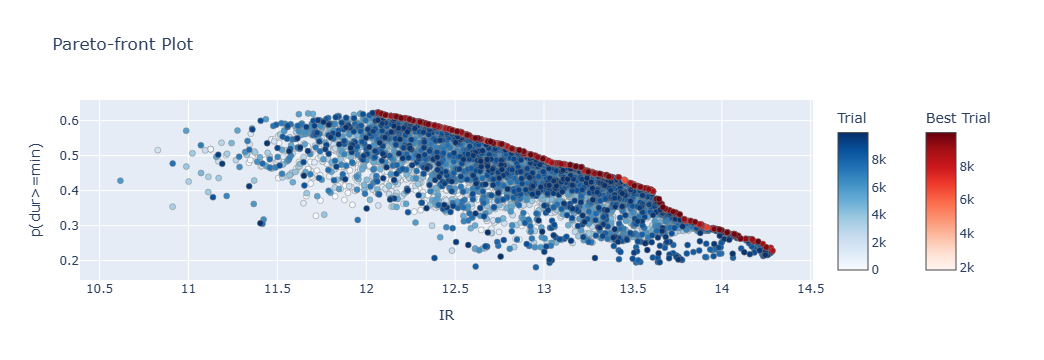

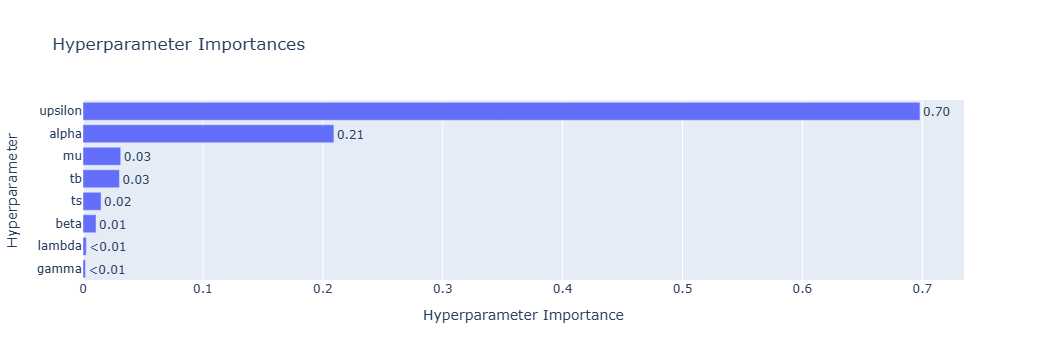

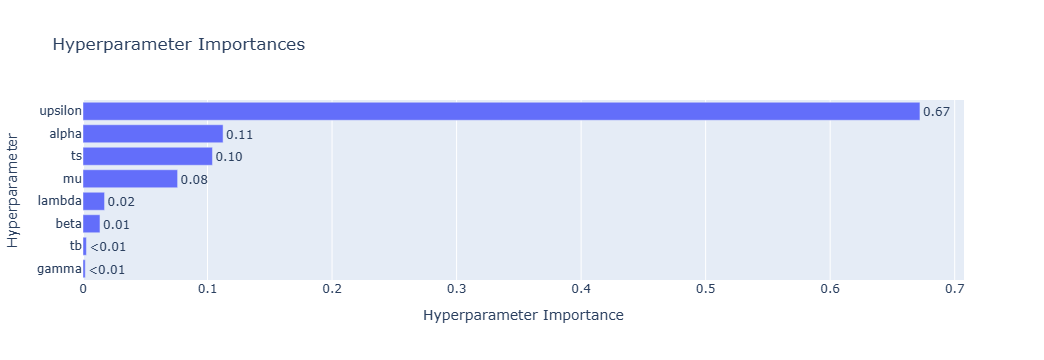

In [6]:
# Define the fixed hyperparameters for the objective function
fixed_params = {'Hb': [10, 15, 20, 25], 'Hs': [3, 5, 10], 'cost': 0.0005}

# Define the hyper parameters for objective function score calculation
opt_params = {'min_duration': 5}

# Init optimization object
optimizer = RewardOptimizer(fixed_params=fixed_params, opt_params=opt_params)

# Run the optimizer
optimizer.run_optimizer(n_trials=10000)

In [7]:
# Get the best hyperparameters
optimizer.get_best_trials()

Number of trials on the Pareto front: 368
Trial with highest information ratio: 
number: 8716
params:
{'alpha': 1.4974158950198897,
 'beta': 0.00227792552676076,
 'gamma': 1.0012556274200186,
 'lambda': 1.015933729514745,
 'mu': 0.8382000761580071,
 'tb': 0.7813175429796064,
 'ts': 0.0014889907443275336,
 'upsilon': 0.05460027408260376}
values: [14.285631549006881, 0.2283062645011601]
Trial with highest trade duration: 
number: 9182
params:
{'alpha': 1.4867958521586264,
 'beta': 0.004529630660020267,
 'gamma': 1.0012556274200186,
 'lambda': 1.0132377939701704,
 'mu': 0.00869931703107829,
 'tb': 0.7813175429796064,
 'ts': 0.9698694433947705,
 'upsilon': 1.4863717552174065}
values: [12.068434681315939, 0.6226267064176997]


# Reward Function Tuning Insights
- Between the reward function hyperparameters that maximize the information ratio and the hyperparameters that maximize the trade durations, significant changes appear to be in $\mu$, $\tau_s$, and $\upsilon$. The equations under consideration are:

$$
\normalsize
r_{\mathrm{hold\mbox{-}out}}^{t}
= \alpha \cdot \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \beta \cdot \max\!\left(0,\,
  \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$

$$
\normalsize
r_{\mathrm{sell}}^{t}
= \lambda \cdot \max\!\left(0,\,
  -\sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right)
  - \mathrm{cost} \cdot \bigl|\Delta \mathrm{pos}\bigr|.
$$

$$
\normalsize
r_{\mathrm{hold\mbox{-}in}}^{t}
= \max\!\left(0,\,
  \upsilon \cdot \sum_{h \in H_b} w_{h,H_b,\tau_b}^{+}(t)\, R_h^{\mathrm{ex}}(t)
  + \mu \cdot \sum_{h \in H_s} w_{h,H_s,\tau_s}^{-}(t)\, R_h^{\mathrm{ex}}(t)\right).
$$

- To improve the trade duration, $\tau_{s,\textrm{ Dur}}$ is significantly higher compared to $\tau_{s,\textrm{ IR}}$. This may suggest that hold-out, sell, and hold-in become resiliant, or less reactive to short term movements in prices. In particular, with the higher $\tau_s$ value:
    - In the hold out function, the negative returns, if any, in the short-term horizons are smoothned or averaged out. Thus, it hold out function becomes more cautious in giving a positive reward for holdout in highly volatile markets with sharp negative returns.
    - Similarly, in the sell function, it becomes less reactive to sudden sharp price drops (for certain horizons), and only gives a strong positive reward if there is a sustained negative returns in all the short term horizons (suggesting a trend reversal). Thus, the reward function supports being in trade and becomes less reactive.
    - The hold in function similarly only gives a penalty for holding if there is a sustained short term trend reversal. Otherwise, encourages to be in trade if only some short term horizons are negative as it averages or smooths out the weighted short term returns.
- Another change that increases trade duration is increasing $\upsilon$ and decreasing $\mu$, thus effectively emphasizing the long term gains and discounting the short term losses while computing the hold in reward, making it less reactive and supporting being in the trade longer.

In [8]:
# Thus we will choose a configuration that balances both the metrics, but leans towards trade duration
optimizer.get_trial_params(trial_number=9618)

{'tb': 0.8338406125641489,
 'ts': 0.3069956262932672,
 'gamma': 1.0012556274200186,
 'alpha': 1.4974158950198897,
 'beta': 0.004529630660020267,
 'lambda': 1.086277483201234,
 'upsilon': 0.41132186313804114,
 'mu': 0.4705709098889538}